# U-Net

In [52]:
%load_ext autoreload

%autoreload 2
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray.plot as xplt
import cftime

In [54]:
import torch
import os, sys
dir2 = os.path.abspath('../../unet/unet')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
import unet

In [55]:
import pysteps

In [56]:
cp_model_rotated_pole = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
platecarree = ccrs.PlateCarree()

In [20]:
cpmdata = xr.open_mfdataset("../../../../data/2.2km/rcp85/01/pr/*.nc").rename({"pr": "target_pr"})
cpmdata = cpmdata.loc[dict(ensemble_member=1, time=slice("1980-12-01","1982-11-30"))]
cpmdata = cpmdata.reset_coords()[['target_pr']]
cpmdata

<xarray.Dataset>
Dimensions:         (grid_latitude: 606, grid_longitude: 484, time: 720)
Coordinates:
  * time            (time) object 1980-12-01 12:00:00 ... 1982-11-30 12:00:00
  * grid_latitude   (grid_latitude) float64 -4.683 -4.647 -4.611 ... 8.027 8.063
  * grid_longitude  (grid_longitude) float64 353.9 354.0 354.0 ... 364.3 364.3
Data variables:
    target_pr       (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(360, 606, 484), meta=np.ndarray>
Attributes: (12/15)
    collection:      land-cpm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2019-07-30T06:13:12
    domain:          uk
    frequency:       day
    institution:     Met Office Hadley Centre (MOHC), FitzRoy Road, Exeter, D...
    ...              ...
    resolution:      2.2km
    scenario:        rcp85
    source:          UKCP18 realisation from a set of 12 convection-permittin...
    title:           UKCP18 land projections - 2.2km convection-permitting cl...
    version:         v20190731
    Conventions:     CF-1.5

In [21]:
regridded_gcmdata = xr.open_mfdataset('../../../../derived_data/60km/rcp85/01/*/day/*.nc')
regridded_gcmdata = regridded_gcmdata.loc[dict(ensemble_member=1, time=slice("1980-12-01","1982-11-30"))]
regridded_gcmdata = regridded_gcmdata.reset_coords()[['pr', 'psl']]
regridded_gcmdata

<xarray.Dataset>
Dimensions:         (grid_latitude: 606, grid_longitude: 484, time: 720)
Coordinates:
  * time            (time) object 1980-12-01 12:00:00 ... 1982-11-30 12:00:00
  * grid_latitude   (grid_latitude) float64 -4.683 -4.647 -4.611 ... 8.027 8.063
  * grid_longitude  (grid_longitude) float64 353.9 354.0 354.0 ... 364.3 364.3
Data variables:
    pr              (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(720, 606, 484), meta=np.ndarray>
    psl             (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(720, 606, 484), meta=np.ndarray>
Attributes: (12/18)
    collection:      land-gcm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2018-11-03T10:11:47
    description:     Precipitation rate
    domain:          uk
    frequency:       day
    ...              ...
    resolution:      60km
    scenario:        rcp85
    source:          UKCP18 global realisation from a set of 15 perturbed var...
    title:           UKCP18 land projections - 60km global climate model, pre...
    version:         v20181122
    Conventions:     CF-1.7

In [22]:
merged_data = xr.merge([regridded_gcmdata, cpmdata])
# select a small subset of the data for trial purposes
# merged_data = merged_data.isel({"grid_latitude": slice(512), "grid_longitude": slice(512)})

# split training/test based on date
training_data = merged_data.sel({"time": slice("1980-12-01", "1981-11-30")})
validation_data = merged_data.sel({"time": slice("1981-12-01", "1982-05-30")})
test_data = merged_data.sel({"time": slice("1982-06-01", "1982-11-30")})

In [9]:
training_data

<xarray.Dataset>
Dimensions:         (grid_latitude: 606, grid_longitude: 484, time: 360)
Coordinates:
  * time            (time) object 1980-12-01 12:00:00 ... 1981-11-30 12:00:00
  * grid_latitude   (grid_latitude) float64 -4.683 -4.647 -4.611 ... 8.027 8.063
  * grid_longitude  (grid_longitude) float64 353.9 354.0 354.0 ... 364.3 364.3
Data variables:
    pr              (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(360, 606, 484), meta=np.ndarray>
    psl             (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(360, 606, 484), meta=np.ndarray>
    target_pr       (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(360, 606, 484), meta=np.ndarray>
Attributes: (12/18)
    collection:      land-gcm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2018-11-03T10:11:47
    description:     Precipitation rate
    domain:          uk
    frequency:       day
    ...              ...
    resolution:      60km
    scenario:        rcp85
    source:          UKCP18 global realisation from a set of 15 perturbed var...
    title:           UKCP18 land projections - 60km global climate model, pre...
    version:         v20181122
    Conventions:     CF-1.7

In [10]:
validation_data

<xarray.Dataset>
Dimensions:         (grid_latitude: 606, grid_longitude: 484, time: 180)
Coordinates:
  * time            (time) object 1981-12-01 12:00:00 ... 1982-05-30 12:00:00
  * grid_latitude   (grid_latitude) float64 -4.683 -4.647 -4.611 ... 8.027 8.063
  * grid_longitude  (grid_longitude) float64 353.9 354.0 354.0 ... 364.3 364.3
Data variables:
    pr              (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(180, 606, 484), meta=np.ndarray>
    psl             (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(180, 606, 484), meta=np.ndarray>
    target_pr       (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(180, 606, 484), meta=np.ndarray>
Attributes: (12/18)
    collection:      land-gcm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2018-11-03T10:11:47
    description:     Precipitation rate
    domain:          uk
    frequency:       day
    ...              ...
    resolution:      60km
    scenario:        rcp85
    source:          UKCP18 global realisation from a set of 15 perturbed var...
    title:           UKCP18 land projections - 60km global climate model, pre...
    version:         v20181122
    Conventions:     CF-1.7

In [11]:
test_data

<xarray.Dataset>
Dimensions:         (grid_latitude: 606, grid_longitude: 484, time: 180)
Coordinates:
  * time            (time) object 1982-06-01 12:00:00 ... 1982-11-30 12:00:00
  * grid_latitude   (grid_latitude) float64 -4.683 -4.647 -4.611 ... 8.027 8.063
  * grid_longitude  (grid_longitude) float64 353.9 354.0 354.0 ... 364.3 364.3
Data variables:
    pr              (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(180, 606, 484), meta=np.ndarray>
    psl             (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(180, 606, 484), meta=np.ndarray>
    target_pr       (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(180, 606, 484), meta=np.ndarray>
Attributes: (12/18)
    collection:      land-gcm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2018-11-03T10:11:47
    description:     Precipitation rate
    domain:          uk
    frequency:       day
    ...              ...
    resolution:      60km
    scenario:        rcp85
    source:          UKCP18 global realisation from a set of 15 perturbed var...
    title:           UKCP18 land projections - 60km global climate model, pre...
    version:         v20181122
    Conventions:     CF-1.7

In [12]:
model = unet.UNet(2, 1)
model

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [23]:
box_size = 32
batch_size = 4
epochs = 10

bl_long_idx = 250
bl_lat_idx = 150

latlong_ibox = {"grid_latitude": slice(bl_lat_idx, bl_lat_idx+box_size), "grid_longitude": slice(bl_long_idx, bl_long_idx+box_size)}

In [14]:
batch = training_data.isel(latlong_ibox).isel({"time": slice(batch_size)})
training_tensor = torch.stack((torch.from_numpy(batch.psl.values),  torch.from_numpy(batch.pr.values)), dim=1)
output = model(training_tensor)
labels = torch.from_numpy(batch.target_pr.values)

/home/henry/anaconda3/envs/downscaling/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448222085/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [15]:
model = unet.UNet(2, 1)

In [16]:
criterion = torch.nn.L1Loss(reduction='mean')

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

In [18]:
for epoch in range(epochs):
    model.train()
    
    epoch_loss = 0
    for i in range(len(training_data.time)//batch_size):
        training_batch = training_data.isel(latlong_ibox).isel({"time": slice(i*batch_size, (i+1)*batch_size)})

        training_batch_inputs_tensor = torch.stack((torch.from_numpy(training_batch.psl.values),  torch.from_numpy(training_batch.pr.values)), dim=1)
        training_batch_labels_tensor = torch.from_numpy(training_batch.target_pr.values)
        
        # Compute prediction and loss
        training_batch_outputs_tensor = model(training_batch_inputs_tensor)
        loss = criterion(training_batch_outputs_tensor.squeeze(), training_batch_labels_tensor)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Progress
        epoch_loss += loss.item()
        if (i+1) % 30 == 0:
            print(f"Epoch {epoch}: Batch {i} Loss {loss.item()}")
    
    model.eval()

    epoch_val_loss = 0
    for i in range(len(validation_data.time)//batch_size):
        with torch.no_grad():
            val_batch = validation_data.isel(latlong_ibox).isel({"time": slice(i*batch_size, (i+1)*batch_size)})

            val_batch_inputs_tensor = torch.stack((torch.from_numpy(val_batch.psl.values),  torch.from_numpy(val_batch.pr.values)), dim=1)
            val_batch_labels_tensor = torch.from_numpy(val_batch.target_pr.values)

            # Compute prediction and loss
            val_batch_outputs_tensor = model(val_batch_inputs_tensor)
            val_loss = criterion(val_batch_outputs_tensor.squeeze(), val_batch_labels_tensor)
        
        
        # Progress
        epoch_val_loss += val_loss.item()

    print(f"Epoch {epoch}: Loss {epoch_loss} Val loss {epoch_val_loss}")
        
    model.train()

Epoch 0: Batch 29 Loss 1.959760308265686
Epoch 0: Batch 59 Loss 0.3114429712295532
Epoch 0: Batch 89 Loss 2.74519681930542
Epoch 0: Loss 328.5888522081077 Val loss 192.73089177161455
Epoch 1: Batch 29 Loss 1.8642767667770386
Epoch 1: Batch 59 Loss 0.43786635994911194
Epoch 1: Batch 89 Loss 2.518425464630127
Epoch 1: Loss 323.7140281647444 Val loss 155.87900541722775
Epoch 2: Batch 29 Loss 1.8643368482589722
Epoch 2: Batch 59 Loss 0.4977653920650482
Epoch 2: Batch 89 Loss 2.3852431774139404
Epoch 2: Loss 318.3019268512726 Val loss 201.32941237092018
Epoch 3: Batch 29 Loss 1.7666409015655518
Epoch 3: Batch 59 Loss 0.6120379567146301
Epoch 3: Batch 89 Loss 2.2818877696990967
Epoch 3: Loss 317.676699757576 Val loss 168.69057635217905
Epoch 4: Batch 29 Loss 1.8198400735855103
Epoch 4: Batch 59 Loss 0.5585862398147583
Epoch 4: Batch 89 Loss 2.3172526359558105
Epoch 4: Loss 316.13599583506584 Val loss 168.53843388706446
Epoch 5: Batch 29 Loss 1.76386296749115
Epoch 5: Batch 59 Loss 0.59319853

In [19]:
model.eval()
with torch.no_grad():
    test_batch = test_data.isel(latlong_ibox).isel({"time": slice(0*batch_size, (0+1)*batch_size)})
    test_batch_inputs_tensor = torch.stack((torch.from_numpy(test_batch.psl.values),  torch.from_numpy(test_batch.pr.values)), dim=1)
    test_batch_outputs_tensor = model(test_batch_inputs_tensor)
model.train()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

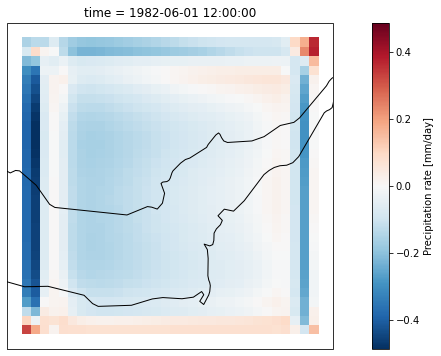

In [20]:
test_data['pred_pr'] = xr.full_like(test_data.target_pr, fill_value=0)
# test_data['new_var'] = xr.where(pr_single_day['new_var'].coords["grid_latitude"] < 0, 100, pr_single_day["new_var"])
test_data['pred_pr'][{**latlong_ibox, "time": slice(0*batch_size, (0+1)*batch_size)}] = test_batch_outputs_tensor.squeeze().numpy()

plt.figure(figsize=(14,6))

ax = plt.axes(projection=cp_model_rotated_pole)
ax.coastlines()

# xplt.plot(test_data['pred_pr'][{"grid_latitude": slice(box_size*12), "grid_longitude": slice(box_size*12)}][{"time": 0}], x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole)
xplt.plot(test_data['pred_pr'][{**latlong_ibox, "time": 0}], x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole)

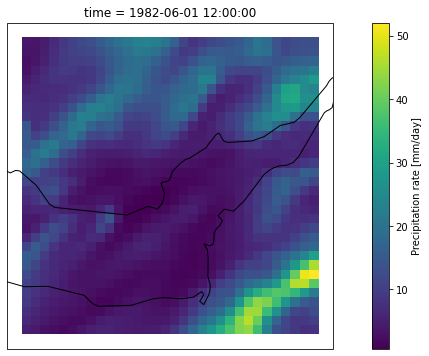

In [21]:
plt.figure(figsize=(14,6))

ax = plt.axes(projection=cp_model_rotated_pole)
ax.coastlines()

xplt.plot(test_data['target_pr'][{**latlong_ibox, "time": 0}], x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole)

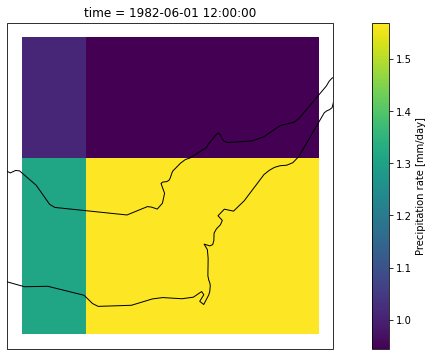

In [22]:
plt.figure(figsize=(14,6))

ax = plt.axes(projection=cp_model_rotated_pole)
ax.coastlines()

xplt.plot(test_data['pr'][{**latlong_ibox, "time": 0}], x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole)

In [29]:
(
    regridded_gcmdata.isel(latlong_ibox).isel({"time": slice(batch_size)}).grid_longitude.min(), regridded_gcmdata.isel(latlong_ibox).isel({"time": slice(batch_size)}).grid_longitude.max(),
    regridded_gcmdata.isel(latlong_ibox).isel({"time": slice(batch_size)}).grid_latitude.min(), regridded_gcmdata.isel(latlong_ibox).isel({"time": slice(batch_size)}).grid_latitude.max()
)

(<xarray.DataArray 'grid_longitude' ()>
 array(359.29074097),
 <xarray.DataArray 'grid_longitude' ()>
 array(359.91073608),
 <xarray.DataArray 'grid_latitude' ()>
 array(-1.35994995),
 <xarray.DataArray 'grid_latitude' ()>
 array(-0.73995))

# Blue Pebble trained model

In [58]:
model = torch.load('../../checkpoints/3769712.bp1/model-epoch30.pth', map_location=torch.device('cpu'))

In [59]:
hi_res_data = xr.open_mfdataset("../../../../derived_data/2.2km-london/rcp85/01/pr/day/*.nc").isel(ensemble_member=0, time=slice(60))
hi_res_data

<xarray.Dataset>
Dimensions:                     (bnds: 2, grid_latitude: 60, grid_longitude: 60, time: 60)
Coordinates:
    ensemble_member             int32 1
  * time                        (time) object 1980-12-01 12:00:00 ... 1981-01...
  * grid_latitude               (grid_latitude) float64 -1.58 -1.56 ... -0.3999
  * grid_longitude              (grid_longitude) float64 360.9 360.9 ... 362.1
    ensemble_member_id          |S27 dask.array<chunksize=(), meta=np.ndarray>
    latitude                    (grid_latitude, grid_longitude) float64 dask.array<chunksize=(60, 60), meta=np.ndarray>
    longitude                   (grid_latitude, grid_longitude) float64 dask.array<chunksize=(60, 60), meta=np.ndarray>
    month_number                (time) int32 dask.array<chunksize=(60,), meta=np.ndarray>
    year                        (time) int32 dask.array<chunksize=(60,), meta=np.ndarray>
    yyyymmdd                    (time) |S64 dask.array<chunksize=(60,), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    pr                          (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(60, 60, 60), meta=np.ndarray>
    rotated_latitude_longitude  (time) int32 -2147483647 ... -2147483647
    time_bnds                   (time, bnds) object dask.array<chunksize=(60, 2), meta=np.ndarray>
    grid_latitude_bnds          (time, grid_latitude, bnds) float64 dask.array<chunksize=(60, 60, 2), meta=np.ndarray>
    grid_longitude_bnds         (time, grid_longitude, bnds) float64 dask.array<chunksize=(60, 60, 2), meta=np.ndarray>
Attributes: (12/15)
    collection:      land-cpm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2019-07-30T06:13:12
    domain:          uk
    frequency:       day
    institution:     Met Office Hadley Centre (MOHC), FitzRoy Road, Exeter, D...
    ...              ...
    resolution:      2.2km
    scenario:        rcp85
    source:          UKCP18 realisation from a set of 12 convection-permittin...
    title:           UKCP18 land projections - 2.2km convection-permitting cl...
    version:         v20190731
    Conventions:     CF-1.5

In [60]:
lo_res_data = xr.open_mfdataset("../../../../derived_data/60km-2.2km-regrid-lin-london/rcp85/01/pr/day/*.nc").isel(ensemble_member=0, time=slice(60))
lo_res_data

<xarray.Dataset>
Dimensions:                     (bnds: 2, grid_latitude: 60, grid_longitude: 60, time: 60)
Coordinates:
    ensemble_member             int32 1
  * time                        (time) object 1980-12-01 12:00:00 ... 1981-01...
  * grid_latitude               (grid_latitude) float64 -1.58 -1.56 ... -0.3999
  * grid_longitude              (grid_longitude) float64 360.9 360.9 ... 362.1
    ensemble_member_id          |S27 dask.array<chunksize=(), meta=np.ndarray>
    month_number                (time) int32 dask.array<chunksize=(60,), meta=np.ndarray>
    year                        (time) int32 dask.array<chunksize=(60,), meta=np.ndarray>
    yyyymmdd                    (time) |S64 dask.array<chunksize=(60,), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    pr                          (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(60, 60, 60), meta=np.ndarray>
    rotated_latitude_longitude  (time) int32 -2147483647 ... -2147483647
    time_bnds                   (time, bnds) object dask.array<chunksize=(60, 2), meta=np.ndarray>
    grid_latitude_bnds          (time, grid_latitude, bnds) float64 dask.array<chunksize=(60, 60, 2), meta=np.ndarray>
    grid_longitude_bnds         (time, grid_longitude, bnds) float64 dask.array<chunksize=(60, 60, 2), meta=np.ndarray>
Attributes: (12/18)
    collection:      land-gcm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2018-11-03T10:11:47
    description:     Precipitation rate
    domain:          uk
    frequency:       day
    ...              ...
    resolution:      60km
    scenario:        rcp85
    source:          UKCP18 global realisation from a set of 15 perturbed var...
    title:           UKCP18 land projections - 60km global climate model, pre...
    version:         v20181122
    Conventions:     CF-1.7

In [61]:
pred = model(torch.stack([torch.tensor(lo_res_data.pr.values)], dim=1))

hi_res_data['pred_pr'] = xr.DataArray(pred.squeeze().detach().numpy(), dims=["time", "grid_longitude", "grid_latitude"])

#hi_res_data['pred_pr'] = xr.full_like(hi_res_data['pr'], fill_value=0)

#hi_res_data['pred_pr'] = pred.detach().squeeze()

In [62]:
def plot(data, variable='pr', title='hello'):
    plt.figure(figsize=(14,6))

    ax = plt.axes(projection=cp_model_rotated_pole)
    ax.coastlines()

    xplt.plot(data[variable], x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole)
    ax.set_title(title)
    plt.show()

In [63]:
lo_res_data.sum(dim=["grid_longitude", "grid_latitude"]).pr.argmax(dim="time").values

array(42)

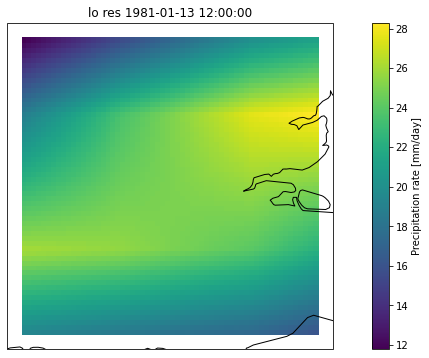

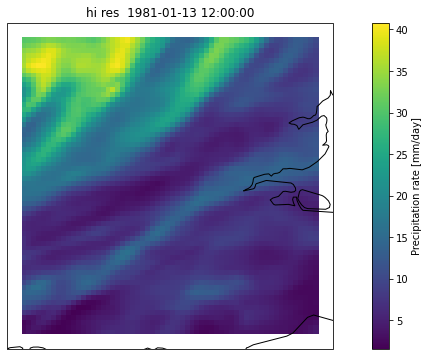

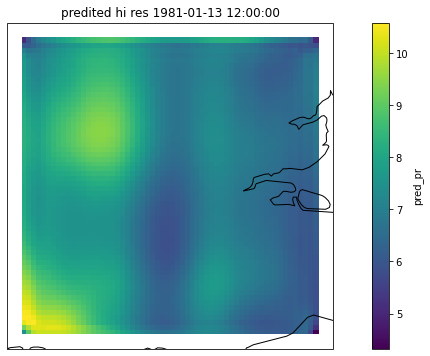

In [64]:
plot(lo_res_data.isel(time=42), title=f'lo res {lo_res_data.time.values[42]}')
plot(hi_res_data.isel(time=42), title=f'hi res  {hi_res_data.time.values[42]}')
plot(hi_res_data.isel(time=42), variable='pred_pr', title=f'predited hi res {hi_res_data.time.values[42]}')

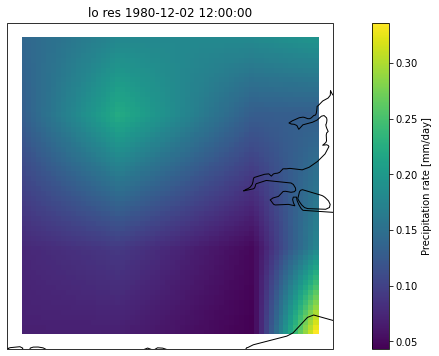

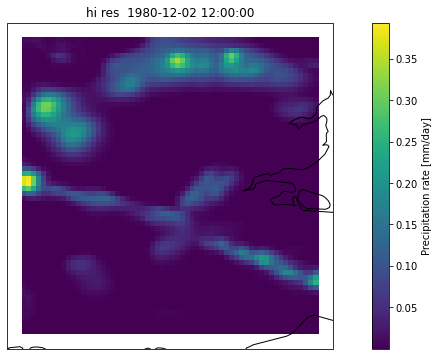

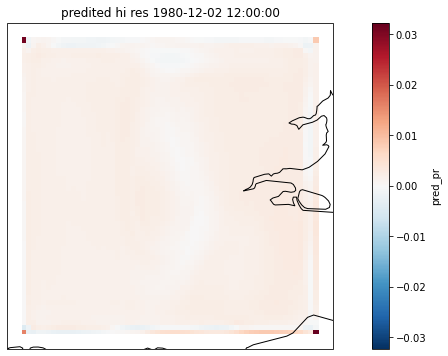

In [65]:
plot(lo_res_data.isel(time=1), title=f'lo res {lo_res_data.time.values[1]}')
plot(hi_res_data.isel(time=1), title=f'hi res  {hi_res_data.time.values[1]}')
plot(hi_res_data.isel(time=1), variable='pred_pr', title=f'predited hi res {hi_res_data.time.values[1]}')

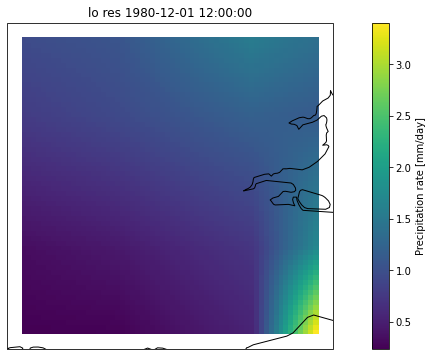

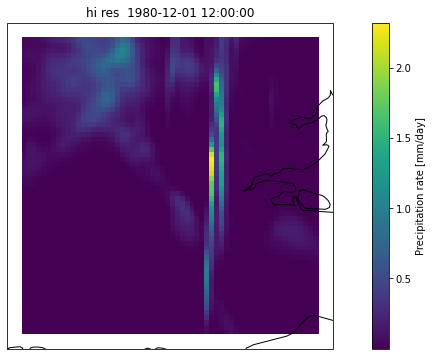

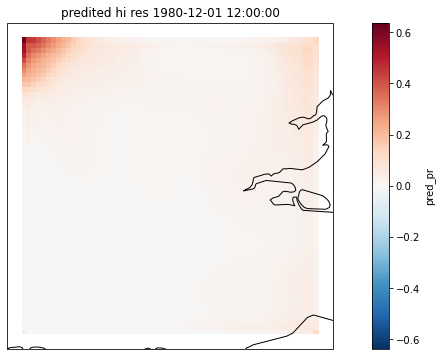

In [66]:
plot(lo_res_data.isel(time=0), title=f'lo res {lo_res_data.time.values[0]}')
plot(hi_res_data.isel(time=0), title=f'hi res  {hi_res_data.time.values[0]}')
plot(hi_res_data.isel(time=0), variable='pred_pr', title=f'predited hi res {hi_res_data.time.values[0]}')